# Minimum Dominating Set Problem

## Graph Construction

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

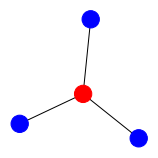

In [2]:
# smaller testing graph
graph_edges = [(0,1), (1,2), (1,3)]
adj = defaultdict(lambda:[])
for (i,j) in graph_edges:
    adj[i].append(j)
    adj[j].append(i)
    
for i in adj.keys():
    adj[i].append(i) # connection to itself
N = len(adj)
dominating_set = [1]
G = nx.Graph()
G.add_edges_from(graph_edges)
plt.figure(figsize=(2,2))
nx.draw(G, node_color=["red" if x in dominating_set else "blue" for x in range(len(adj.keys()))])
plt.show()

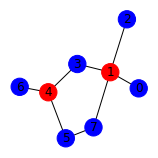

In [187]:
# bigger graph
graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6), (5, 7), (1, 7)]
adj = defaultdict(lambda:[])
for (i,j) in graph_edges:
    adj[i].append(j)
    adj[j].append(i)
    
for i in adj.keys():
    adj[i].append(i) # connection to itself
N = len(adj)
dominating_set = [1, 4]
G = nx.Graph()
G.add_edges_from(graph_edges)
plt.figure(figsize=(2,2))
nx.draw(G, node_color=["red" if x in dominating_set else "blue" for x in range(8)], labels={node: node for node in G.nodes()})
plt.show()

## Cost Hamiltonian

In [3]:
from typing import List, Tuple, Any, Dict
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

In [4]:
def qaoa_graph_to_cost_hamiltonian(adj:Dict[int, List[int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = defaultdict(lambda:0)
    N = len(adj.keys())
    for node in range(N):
        for i in range(1<<(len(adj[node]))):
            qubits = []
            for j in range(len(adj[node])):
                if (i&(1<<j)):
                       qubits.append(Qubit(adj[node][j]))
            term_string = QubitPauliString(qubits, [Pauli.Z]*len(qubits))
            # print(node, term_string)
            qpo_dict[term_string]-=(1/2)**len(adj[node])
    objective_scaling = 0.5
    for node in range(N):
        term_string = QubitPauliString()
        qpo_dict[term_string] -= 1/2*objective_scaling
        term_string = QubitPauliString([Qubit(node)], [Pauli.Z])
        qpo_dict[term_string] += 1/2*objective_scaling
        
    for key in qpo_dict.keys():
        qpo_dict[key]*=cost_angle
    
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(adj, cost_angle)
print(cost_ham_qpo)

{(): -1.81250000000000, (Zq[1]): -0.562500000000000, (Zq[0]): -0.0625000000000000, (Zq[0], Zq[1]): -0.312500000000000, (Zq[2]): -0.0625000000000000, (Zq[0], Zq[2]): -0.0625000000000000, (Zq[3]): -0.0625000000000000, (Zq[0], Zq[3]): -0.0625000000000000, (Zq[2], Zq[3]): -0.0625000000000000, (Zq[0], Zq[2], Zq[3]): -0.0625000000000000, (Zq[1], Zq[2]): -0.312500000000000, (Zq[0], Zq[1], Zq[2]): -0.0625000000000000, (Zq[1], Zq[3]): -0.312500000000000, (Zq[0], Zq[1], Zq[3]): -0.0625000000000000, (Zq[1], Zq[2], Zq[3]): -0.0625000000000000, (Zq[0], Zq[1], Zq[2], Zq[3]): -0.0625000000000000}


In [13]:
from pytket import Circuit

circ = Circuit(8)

circ.X(1)
circ.X(3)
# circ.X(7)
vec = circ.get_statevector()

In [14]:
cost_ham_qpo.state_expectation(vec)

(-1+0j)

## Cost Hamiltonian Circuit

In [15]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(N))
display.render_circuit_jupyter(cost_ham_circuit)

In [16]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

## Mixer Hamiltonian

In [17]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(N)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(N))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

## Initial Circuit

In [18]:
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(N)

display.render_circuit_jupyter(superposition_circuit)

## Putting it all together

In [19]:
def qaoa_dominating_set_circuit(adj:Dict[int, List[int]],
                         n_nodes: int,
                         mixer_angles: List[float],
                         cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = qaoa_initial_circuit(n_nodes)
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(adj, cost)
        mixer_ham = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)})
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

In [20]:
from typing import List, Tuple
from pytket.backends.backendresult import BackendResult

def sat_dominating_set(adj:Dict[int, List[int]], meas):
    # how many dominating set constrainst are satisfied 
    num = 0
    for node in adj.keys():
        sat = 0
        for x in adj[node]:
            if meas[x] == 1:
                sat = 1
        num+=sat
    return num

def get_energy(adj:Dict[int, List[int]], results: BackendResult) -> float:
    dist = results.get_distribution()
    energy = 0.0
    for meas, prob in dist.items():
        energy += (sat_dominating_set(adj, meas)  - len(adj) - 0.1*sum(meas))*prob

    return energy

In [21]:
from pytket.backends.backend import Backend
from typing import Callable
import numpy as np

def qaoa_instance(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    seed: int,
    shots: int = 5000,
) -> float:
    # step 1: get state guess
    my_prep_circuit = qaoa_dominating_set_circuit(
        adj, N, guess_mixer_angles, guess_cost_angles
    )
    measured_circ = my_prep_circuit.copy().measure_all()
    compiler_pass(measured_circ)
    res = backend.run_circuit(measured_circ, shots, seed=seed)

    return get_energy(adj, res)

In [22]:
def qaoa_optimise_energy(compiler_pass: Callable[[Circuit], bool],
                         backend: Backend,
                         iterations: int = 100,
                         n: int = 3,
                         shots: int = 5000,
                         seed: int= 12345):
    
    highest_energy = -1000   
    best_guess_mixer_angles = [0 for i in range(n)]    
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)
    # guess some angles (iterations)-times and try if they are better than the best angles found before
    
    for i in range(iterations):
        
        guess_mixer_angles = rng.uniform(0, 1, n)
        guess_cost_angles = rng.uniform(0, 1, n)
        
        qaoa_energy = qaoa_instance(backend,
                                    compiler_pass,
                                    guess_mixer_angles,
                                    guess_cost_angles,
                                    seed=seed,
                                    shots=shots)
        
        if(qaoa_energy > highest_energy):
            
            print("new highest energy found: ", qaoa_energy)
            
            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles

In [23]:
def qaoa_calculate(backend: Backend,
                   compiler_pass: Callable[[Circuit], bool],
                   shots: int = 5000,
                   iterations: int = 100,
                   seed: int = 12345,
                  ) -> BackendResult:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 3,
                                                 shots=shots,
                                                 seed=seed)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_dominating_set_circuit(adj,
                                           N,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots, seed=seed)

    result = backend.get_result(handle)    
    
    return result

In [24]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

In [25]:
%%time
res = qaoa_calculate(backend, backend.default_compilation_pass(2).apply, shots = 100, iterations = 20, seed=12345)

new highest energy found:  -1.1560000000000001
new highest energy found:  -0.955
new highest energy found:  -0.32600000000000007
highest energy:  -0.32600000000000007
best guess mixer angles:  [0.734 0.22  0.082]
best guess cost angles:  [0.16  0.34  0.465]
CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


In [26]:
def prob_each_node(dist):
    p = [0]*N
    for meas, prob in dist.items():
        for ind, val in enumerate(meas):
            if (val == 1): 
                p[ind] +=prob
    return p

In [27]:
prob_each_node(res.get_distribution())

[0.42, 0.8, 0.52, 0.42]

In [151]:
get_energy(adj, res)

-0.32600000000000007